<a href="https://colab.research.google.com/github/gmojko/fastai_learning/blob/main/Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define functions to search and download images

In [13]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')
          #L - Behaves like a list of `items` but can also index with list of indices or masks

In [14]:
from pathlib import Path
path = Path("drive/MyDrive") / "Colab Notebooks" / "FastAI/data/"

In [15]:
path.ls()

(#1) [Path('drive/MyDrive/Colab Notebooks/FastAI/data/crushed_car.jpg')]

Searching for 'damaged passenger car dark'


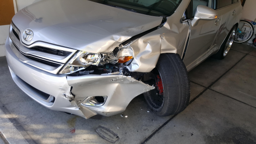

In [16]:
from fastdownload import download_url
dest = path / 'crushed_car5.jpg'
#dest = 'crushed_car1.jpg'
urls = search_images('damaged passenger car dark', max_images=1)
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [17]:
searches = 'damaged car','car'
path = Path("drive/MyDrive") / "Colab Notebooks" / "FastAI/data/"
from time import sleep

for o in searches:
    dest = (path/o)
    #dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} green'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} black'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} white'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'damaged car green'
Searching for 'damaged car black'
Searching for 'damaged car white'
Searching for 'car green'
Searching for 'car black'
Searching for 'car white'


In [ ]:
#path.ls()[1].unlink()

Path('drive/MyDrive/Colab Notebooks/FastAI/data/a')

Check if image is valid and if not delete it from folder

In [18]:
from fastai.vision.all import *
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

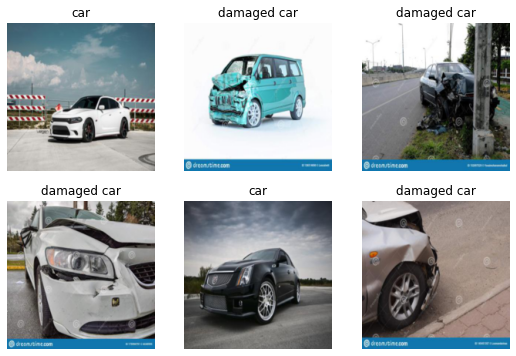

In [19]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

# alternative way is to use ImageDataLoaders:

#def is_cat(x): return x[0].isupper() #images of cats start with capital letter

# dls = ImageDataLoaders.from_name_func('.',
#    get_image_files(path), valid_pct=0.2, seed=42,
#    label_func=is_cat,
#    item_tfms=Resize(192))


dls.show_batch(max_n=6)

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.918435,0.099675,0.017241,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.186744,0.123024,0.017241,00:03
1,0.117988,0.157987,0.017241,00:02
2,0.082384,0.141525,0.017241,00:02


In [ ]:
is_damaged,_,probs = learn.predict(PILImage.create(path / 'crushed_car5.jpg'))
print(f"This is a: {is_damaged}.")
print(f"Probability it's a damaged passenger car: {probs[0]:.4f}")

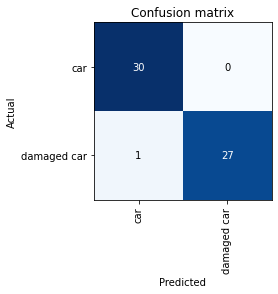

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

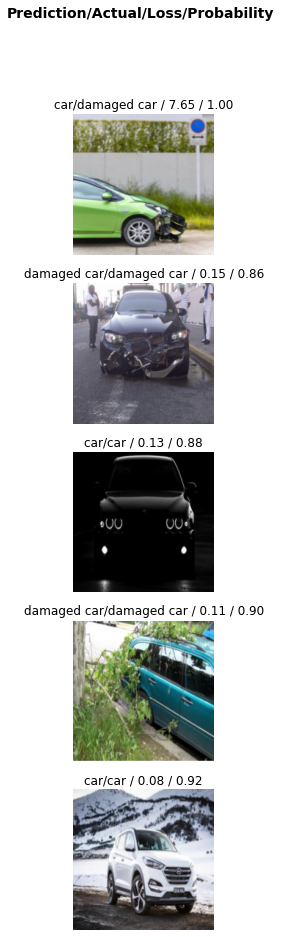

In [23]:
interp.plot_top_losses(5, nrows=5)

In [ ]:
??ImageClassifierCleaner

In [24]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

# ImageClassifierCleaner does not delete images but only label them. In order to remove them try next cell.

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.916677,0.327801,0.132075,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.359656,0.211007,0.075472,00:44
1,0.214111,0.243426,0.075472,00:42
2,0.147686,0.217901,0.075472,00:40
